In [1]:
import os

import ast
import json


import sys
sys.path.append("../..")
from utils.misc_utils import check_create_folder


import torch
torch.cuda.current_device()

import pickle
torch.set_default_dtype(torch.float64)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from prediction.evaluation import compute_rNMSEs_per_step, compute_iteration_rNMSE
from prediction.pred_utils import get_device, transform_data_to_all_steps_prediction, get_name_string, get_MOLENE_dataset

from architectures.space_time.parametric_pooling_net_ordering import ParametricNetWithPoolingOrdered

device = get_device(use_gpu=True)

Device selected: cuda:0


In [2]:
def itemize_dictionary(dictionary, round_digits):
    for k,i in dictionary.items():
        dictionary[k] = round(i.item(), round_digits)
    return dictionary

def pretty_print_dict(dictionary):
    for key in dictionary:
        print(f"{key}: {dictionary[key][1]} --> {dictionary[key][0]}")

In [3]:
ds_folder = "../"
splits = [0.35, 0.15, 0.5]
obs_window = 4

dataset, steps_ahead, weighted_adjacency = get_MOLENE_dataset(
    ds_folder,
    splits=splits,
    obs_window=obs_window
)
trn_data, val_data, tst_data, trn_labels, val_labels, tst_labels = transform_data_to_all_steps_prediction(dataset, node_first=True, device=device)

N_spatial_nodes = weighted_adjacency.shape[0]

print(f"{N_spatial_nodes} nodes - {obs_window} observed timesteps - steps ahead: {steps_ahead}\n\n")



MOLENE is selected



Dataset path: ..//MOLENE/dataset/processed/dataset_w=4_steps=[1, 2, 3, 4, 5]_splits=[0.35, 0.15, 0.5].pickle
32 nodes - 4 observed timesteps - steps ahead: [1, 2, 3, 4, 5]




# New part

In [4]:
# runs_dir = "C:\\Users\\gabri\\Desktop\\exp_prediction_MOLENE\\experiments_obs=4\\runs_MOLENE_w=4_big_grid_search_mse\\"
runs_dir = "C:\\Users\\gabri\\Desktop\\new_thesis_project\\prediction\\MOLENE\\runs_MOLENE_w=4_old\\"
# runs_dir = "C:\\Users\\gabri\\Desktop\\exp_prediction_MOLENE\\best_models\\"
model_directories = [x[0] for x in os.walk(runs_dir)][1:]
print(len(model_directories))

389


In [5]:
BEST = True
naming = "best" if BEST else "last"

In [6]:
start = 9
model_directories[0].split("_")[start]

'L=2'

In [7]:
models_dicts = []

RECOMPUTE_RESULTS = False

for idx, model_dir in enumerate(model_directories):
    model_name = model_dir.split("\\")[-1]
    
    if idx%10 == 0 or True:
        print("\n")
        print(idx)    
        print(model_name)       
        
    # check if the model already has the json dictionary saved --> no need to compute it again!
    does_file_exist = os.path.isfile(f'{model_dir}/results.json')
    if does_file_exist and not RECOMPUTE_RESULTS:
        print("Results already computed")
        with open(f'{model_dir}/results.json') as json_file:
            model_dict = json.load(json_file)
            pretty_print_dict(model_dict)
            models_dicts.append((model_name, model_dict))
        continue
    else:
        print("Results missing. Computing...")
    
    features = ast.literal_eval(model_dir.split("_")[start].split("=")[1])
    taps = ast.literal_eval(model_dir.split("_")[start+1].split("=")[1])
    pool_ratios = ast.literal_eval(model_dir.split("_")[start+2].split("=")[1])
    reach = ast.literal_eval(model_dir.split("_")[start+3].split("=")[1])
    nodes = ast.literal_eval(model_dir.split("_")[start+4].split("=")[1])
    
    cyclic_time_graph = 'cyclic=True' in model_dir
    time_directed = 'tdirect=False' not in model_dir
    
    feat_per_layer = [1] + features
    taps_per_layer = taps
    pool_reach_per_layer = reach
    active_nodes_per_timestep_per_layer = [N_spatial_nodes] + nodes
    time_pooling_ratio_per_layer = pool_ratios



    one_step_gtcnn = ParametricNetWithPoolingOrdered(
        window=obs_window,
        cyclic_time_graph=cyclic_time_graph,
        time_directed=time_directed,
        S_spatial=weighted_adjacency,
        n_feat_per_layer=feat_per_layer,
        n_taps_per_layer=taps_per_layer,
        n_active_nodes_per_timestep_per_layer=active_nodes_per_timestep_per_layer,
        time_pooling_ratio_per_layer=time_pooling_ratio_per_layer,
        pool_reach_per_layer=pool_reach_per_layer,
        output_dim=N_spatial_nodes,
        device=device)

    one_step_gtcnn.to(device)
    
    
    checkpoint = torch.load(f"{model_dir}/{naming}_one_step_gtcnn.pth") 

    one_step_gtcnn.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    print(epoch)

    one_step_gtcnn.eval()
    
    rNMSEs_dict_trn, _ = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, trn_data, trn_labels, device, verbose=False)
    rNMSEs_dict_trn = itemize_dictionary(rNMSEs_dict_trn, 3)
    avg_rNMSE_trn = round(np.average(list(rNMSEs_dict_trn.values())), 5)
    trn_values = (avg_rNMSE_trn, list(rNMSEs_dict_trn.values()))
    
    rNMSEs_dict_val, _ = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, val_data, val_labels, device, verbose=False)
    rNMSEs_dict_val = itemize_dictionary(rNMSEs_dict_val, 3)
    avg_rNMSE_val = round(np.average(list(rNMSEs_dict_val.values())), 5)
    val_values = (avg_rNMSE_val, list(rNMSEs_dict_val.values()))
    
    rNMSEs_dict_tst, _ = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, tst_data, tst_labels, device, verbose=False)
    rNMSEs_dict_tst = itemize_dictionary(rNMSEs_dict_tst, 3)
    avg_rNMSE_tst = round(np.average(list(rNMSEs_dict_tst.values())), 5)
    tst_values = (avg_rNMSE_tst, list(rNMSEs_dict_tst.values()))
    
    model_dict = {
        'trn': trn_values,
        'val': val_values,
        'tst': tst_values,
    }
    
    models_dicts.append((model_name, model_dict))
    
    with open(f'{model_dir}/results.json', 'w', encoding='utf-8') as f:
        json.dump(model_dict, f, ensure_ascii=False, indent=4)



0
20200228205125_lr=0.005_b=64_w=4_L=2_F=[4, 8]_T=[4, 4]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [1.0, 1.0, 1.0, 1.0, 1.0] --> 1.0
val: [1.0, 1.0, 1.0, 1.0, 1.0] --> 1.0
tst: [1.0, 1.0, 1.0, 1.0, 1.0] --> 1.0


1
20200228205142_lr=0.0025_b=64_w=4_L=2_F=[4, 8]_T=[4, 4]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [1.082, 1.03, 1.578, 1.316, 1.004] --> 1.202
val: [1.009, 1.011, 1.219, 1.115, 0.999] --> 1.0706
tst: [1.005, 1.013, 1.059, 1.034, 0.999] --> 1.022


2
20200228205248_lr=0.0005_b=64_w=4_L=2_F=[4, 8]_T=[4, 4]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [207.805, 6153.244, 244858.598, 7434829.866, 577830584.868] --> 117103326.8762
val: [193.05, 2617.415, 109235.773, 5685395.592, 236521427.807] --> 48463773.9274
tst: [118.638, 2722.161, 136253.992, 5167253.564, 278065233.332] --> 56674316.3374


3
20200228205414_lr=0.001_b=64_w=4_L

val: [0.594, 0.642, 0.666, 0.741, 0.819] --> 0.6924
tst: [0.523, 0.577, 0.608, 0.679, 0.752] --> 0.6278


25
20200229005742_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.51, 0.568, 0.637, 0.709, 0.782] --> 0.6412
val: [0.441, 0.531, 0.624, 0.718, 0.809] --> 0.6246
tst: [0.391, 0.478, 0.562, 0.652, 0.729] --> 0.5624


26
20200229010722_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.558, 0.609, 0.632, 0.687, 0.759] --> 0.649
val: [0.52, 0.586, 0.639, 0.708, 0.786] --> 0.6478
tst: [0.473, 0.534, 0.592, 0.658, 0.733] --> 0.598


27
20200229011253_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.387, 0.469, 0.566, 0.637, 0.711] --> 0.554
val: [0.415, 0.496, 0.586, 0.661, 0.735] --> 0.5786
tst: [0.388, 0.441,

20200229051945_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.333, 0.342, 0.567, 0.512, 0.779] --> 0.5066
val: [0.406, 0.407, 0.654, 0.603, 0.894] --> 0.5928
tst: [0.353, 0.358, 0.551, 0.514, 0.736] --> 0.5024


52
20200229052925_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.264, 0.36, 0.419, 0.506, 0.611] --> 0.432
val: [0.412, 0.578, 0.632, 0.694, 0.808] --> 0.6248
tst: [0.393, 0.534, 0.591, 0.683, 0.804] --> 0.601


53
20200229054150_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.503, 0.603, 0.758, 0.788, 0.884] --> 0.7072
val: [0.631, 0.79, 1.09, 1.165, 1.178] --> 0.9708
tst: [0.63, 0.756, 1.069, 1.13, 1.123] --> 0.9416


54
20200229055305_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[3, 3]_P=[2, 2]_R=[1, 

trn: [0.332, 0.386, 0.509, 0.552, 0.678] --> 0.4914
val: [0.433, 0.468, 0.664, 0.674, 0.87] --> 0.6218
tst: [0.401, 0.436, 0.576, 0.585, 0.707] --> 0.541


78
20200229094912_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.315, 0.438, 0.522, 0.67, 0.818] --> 0.5526
val: [0.47, 0.593, 0.655, 0.81, 1.006] --> 0.7068
tst: [0.423, 0.568, 0.697, 0.888, 1.052] --> 0.7256


79
20200229095518_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.349, 0.362, 0.574, 0.552, 0.788] --> 0.525
val: [0.401, 0.408, 0.609, 0.587, 0.806] --> 0.5622
tst: [0.36, 0.364, 0.551, 0.518, 0.721] --> 0.5028


80
20200229100214_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.32, 0.398, 0.477, 0.569, 0.638] --> 0.4804
val: [0.42, 0.484, 0.566, 0

20200229142642_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.372, 0.522, 0.553, 0.653, 0.733] --> 0.5666
val: [0.423, 0.565, 0.581, 0.657, 0.743] --> 0.5938
tst: [0.411, 0.548, 0.55, 0.637, 0.714] --> 0.572


105
20200229142959_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.361, 0.365, 0.595, 0.568, 0.834] --> 0.5446
val: [0.397, 0.392, 0.586, 0.561, 0.777] --> 0.5426
tst: [0.366, 0.362, 0.566, 0.514, 0.75] --> 0.5116


106
20200229143711_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.264, 0.343, 0.41, 0.512, 0.614] --> 0.4286
val: [0.43, 0.572, 0.639, 0.741, 0.872] --> 0.6508
tst: [0.383, 0.496, 0.55, 0.64, 0.746] --> 0.563


107
20200229144830_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 

trn: [0.33, 0.455, 0.52, 0.641, 0.736] --> 0.5364
val: [0.386, 0.515, 0.544, 0.639, 0.737] --> 0.5642
tst: [0.378, 0.507, 0.53, 0.625, 0.72] --> 0.552


131
20200229205404_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.303, 0.385, 0.507, 0.637, 0.756] --> 0.5176
val: [0.345, 0.401, 0.502, 0.634, 0.766] --> 0.5296
tst: [0.327, 0.391, 0.512, 0.637, 0.758] --> 0.525


132
20200229205747_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.338, 0.461, 0.519, 0.629, 0.718] --> 0.533
val: [0.4, 0.528, 0.555, 0.639, 0.721] --> 0.5686
tst: [0.387, 0.518, 0.534, 0.621, 0.703] --> 0.5526


133
20200229210136_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.292, 0.386, 0.495, 0.614, 0.713] --> 0.5
val: [0.338, 0.403, 0.47

20200301010301_lr=0.001_b=64_w=4_L=2_F=[8, 8]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.518, 0.585, 0.657, 0.729, 0.809] --> 0.6596
val: [0.425, 0.48, 0.572, 0.662, 0.729] --> 0.5736
tst: [0.396, 0.46, 0.552, 0.642, 0.733] --> 0.5566


158
20200301012538_lr=0.001_b=64_w=4_L=2_F=[8, 8]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0_tdirect=False
Results already computed
trn: [1.0, 1.0, 1.0, 1.0, 1.0] --> 1.0
val: [1.001, 1.001, 1.001, 1.001, 1.001] --> 1.001
tst: [1.002, 1.002, 1.002, 1.002, 1.002] --> 1.002


159
20200301012937_lr=0.001_b=64_w=4_L=2_F=[8, 8]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.529, 0.586, 0.658, 0.731, 0.805] --> 0.6618
val: [0.433, 0.524, 0.657, 0.782, 0.896] --> 0.6584
tst: [0.382, 0.465, 0.586, 0.709, 0.825] --> 0.5934


160
20200301015033_lr=0.001_b=64_w=4_L=2_F=[8, 8]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 

trn: [0.819, 0.84, 0.872, 0.899, 0.926] --> 0.8712
val: [0.646, 0.686, 0.737, 0.786, 0.841] --> 0.7392
tst: [0.552, 0.593, 0.649, 0.706, 0.774] --> 0.6548


184
20200301062456_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.671, 0.762, 0.749, 0.839, 0.861] --> 0.7764
val: [0.611, 0.668, 0.699, 0.791, 0.838] --> 0.7214
tst: [0.57, 0.653, 0.677, 0.772, 0.834] --> 0.7012


185
20200301063148_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.394, 0.474, 0.591, 0.669, 0.736] --> 0.5728
val: [0.406, 0.482, 0.595, 0.681, 0.768] --> 0.5864
tst: [0.347, 0.415, 0.53, 0.63, 0.725] --> 0.5294


186
20200301064758_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.776, 0.789, 0.819, 0.846, 0.888] --> 0.8236
val: [0.618, 0.662, 0

tst: [0.445, 0.755, 0.834, 0.997, 1.045] --> 0.8152


210
20200301104525_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.676, 0.724, 0.771, 0.816, 0.857] --> 0.7688
val: [0.752, 0.777, 0.806, 0.84, 0.878] --> 0.8106
tst: [0.762, 0.772, 0.788, 0.803, 0.816] --> 0.7882


211
20200301105820_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.292, 0.364, 0.472, 0.558, 0.647] --> 0.4666
val: [0.352, 0.463, 0.677, 0.846, 1.053] --> 0.6782
tst: [0.338, 0.398, 0.518, 0.631, 0.758] --> 0.5286


212
20200301111957_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.483, 0.54, 0.605, 0.673, 0.754] --> 0.611
val: [0.491, 0.546, 0.617, 0.682, 0.766] --> 0.6204
tst: [0.459, 0.511, 0.58, 0.642, 0.722] --> 0.5828


213
20200301113351_lr

20200301163126_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.272, 0.349, 0.428, 0.542, 0.653] --> 0.4488
val: [0.419, 0.57, 0.619, 0.737, 0.846] --> 0.6382
tst: [0.397, 0.488, 0.557, 0.678, 0.78] --> 0.58


237
20200301163949_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 22]_wd=0.0025_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.387, 0.391, 0.563, 0.575, 0.71] --> 0.5252
val: [0.399, 0.4, 0.559, 0.545, 0.701] --> 0.5208
tst: [0.376, 0.372, 0.545, 0.539, 0.705] --> 0.5074


238
20200301164530_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 22]_wd=0.0025_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.311, 0.397, 0.491, 0.62, 0.719] --> 0.5076
val: [0.414, 0.476, 0.565, 0.67, 0.722] --> 0.5694
tst: [0.396, 0.474, 0.556, 0.669, 0.753] --> 0.5696


239
20200301165643_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[

Results already computed
trn: [0.364, 0.525, 0.572, 0.672, 0.776] --> 0.5818
val: [0.414, 0.559, 0.579, 0.654, 0.751] --> 0.5914
tst: [0.416, 0.587, 0.581, 0.662, 0.754] --> 0.6


263
20200301221852_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.3, 0.398, 0.505, 0.613, 0.71] --> 0.5052
val: [0.34, 0.399, 0.452, 0.522, 0.614] --> 0.4654
tst: [0.321, 0.385, 0.455, 0.54, 0.627] --> 0.4656


264
20200301222253_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0.0025_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.34, 0.468, 0.535, 0.642, 0.73] --> 0.543
val: [0.377, 0.48, 0.5, 0.585, 0.666] --> 0.5216
tst: [0.376, 0.522, 0.564, 0.649, 0.741] --> 0.5704


265
20200301222606_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.383, 0.391, 0.554, 0.588, 0.714] --> 0.5

20200302035042_lr=0.001_b=64_w=4_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.295, 0.404, 0.52, 0.647, 0.762] --> 0.5256
val: [0.338, 0.399, 0.468, 0.55, 0.65] --> 0.481
tst: [0.327, 0.406, 0.476, 0.568, 0.644] --> 0.4842


290
20200302035602_lr=0.001_b=64_w=4_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.348, 0.443, 0.509, 0.614, 0.691] --> 0.521
val: [0.394, 0.491, 0.512, 0.605, 0.689] --> 0.5382
tst: [0.39, 0.501, 0.547, 0.651, 0.736] --> 0.565


291
20200302040009_lr=0.001_b=64_w=4_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.313, 0.417, 0.525, 0.648, 0.746] --> 0.5298
val: [0.354, 0.428, 0.529, 0.652, 0.76] --> 0.5446
tst: [0.331, 0.409, 0.495, 0.607, 0.717] --> 0.5118


292
20200302040410_lr=0.001_b=64_w=4_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd

trn: [0.309, 0.374, 0.477, 0.571, 0.68] --> 0.4822
val: [0.33, 0.431, 0.6, 0.761, 0.943] --> 0.613
tst: [0.302, 0.363, 0.485, 0.629, 0.788] --> 0.5134


316
20200302083134_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.528, 0.577, 0.627, 0.69, 0.767] --> 0.6378
val: [0.528, 0.581, 0.65, 0.721, 0.809] --> 0.6578
tst: [0.481, 0.538, 0.597, 0.666, 0.748] --> 0.606


317
20200302182725_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 22]_wd=0.0025_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.634, 0.695, 0.773, 0.876, 1.013] --> 0.7982
val: [0.759, 0.785, 0.818, 0.86, 0.909] --> 0.8262
tst: [0.776, 0.791, 0.807, 0.826, 0.846] --> 0.8092


318
20200302185007_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 22]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.297, 0.394, 0.544, 0.672, 0.802] --> 0.5418
val: [0.329, 0.

342
20200302221755_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 25]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.318, 0.414, 0.543, 0.658, 0.784] --> 0.5434
val: [0.366, 0.447, 0.568, 0.701, 0.837] --> 0.5838
tst: [0.346, 0.414, 0.53, 0.653, 0.791] --> 0.5468


343
20200302223431_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 25]_wd=0.0025_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.685, 0.726, 0.774, 0.826, 0.876] --> 0.7774
val: [0.71, 0.741, 0.773, 0.813, 0.856] --> 0.7786
tst: [0.679, 0.702, 0.726, 0.749, 0.77] --> 0.7252


344
20200302224324_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 25]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: [0.702, 0.831, 0.781, 0.829, 0.875] --> 0.8036
val: [0.702, 0.731, 0.766, 0.815, 0.864] --> 0.7756
tst: [0.672, 0.697, 0.725, 0.751, 0.775] --> 0.724


345
20200302225127_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[1, 4

trn: [0.29, 0.403, 0.541, 0.674, 0.808] --> 0.5432
val: [0.401, 0.536, 0.656, 0.741, 0.843] --> 0.6354
tst: [0.376, 0.527, 0.696, 0.817, 0.89] --> 0.6612


369
20200303030418_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 25]_wd=0_cyclic=True_r=0_tdirect=False
Results already computed
trn: [0.469, 0.543, 0.593, 0.67, 0.743] --> 0.6036
val: [0.473, 0.573, 0.613, 0.699, 0.781] --> 0.6278
tst: [0.435, 0.52, 0.56, 0.651, 0.728] --> 0.5788


370
20200303031603_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 25]_wd=0_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: [0.339, 0.409, 0.504, 0.592, 0.683] --> 0.5054
val: [0.376, 0.44, 0.541, 0.633, 0.718] --> 0.5416
tst: [0.361, 0.415, 0.51, 0.601, 0.696] --> 0.5166


371
20200303033013_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[3, 3]_P=[2, 2]_R=[1, 1]_N=[25, 25]_wd=0_cyclic=True_r=0.00025_tdirect=False
Results already computed
trn: [0.549, 0.612, 0.692, 0.778, 0.839] --> 0.694
val: [0.469, 0.526, 0.6,

# Sorting the models

In [8]:
models_sorted_by_trn = sorted(models_dicts, key=lambda item: item[1]['trn'][0])
models_sorted_by_val = sorted(models_dicts, key=lambda item: item[1]['val'][0])
models_sorted_by_tst = sorted(models_dicts, key=lambda item: item[1]['tst'][0])

## Best models on val

In [9]:
for idx, (name, dictionary) in enumerate(models_sorted_by_val[:5]):
    print("\n", idx)
    values = name.split('_')
    print(f"Model: {name}")
    print(values[3])
    pretty_print_dict(dictionary)


 0
Model: 20200301221852_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
w=4
trn: [0.3, 0.398, 0.505, 0.613, 0.71] --> 0.5052
val: [0.34, 0.399, 0.452, 0.522, 0.614] --> 0.4654
tst: [0.321, 0.385, 0.455, 0.54, 0.627] --> 0.4656

 1
Model: 20200302225127_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[3, 3]_P=[1, 4]_R=[1, 1]_N=[25, 25]_wd=0_cyclic=True_r=0_tdirect=False
w=4
trn: [0.338, 0.459, 0.532, 0.648, 0.746] --> 0.5446
val: [0.338, 0.412, 0.439, 0.534, 0.627] --> 0.47
tst: [0.339, 0.449, 0.508, 0.641, 0.765] --> 0.5404

 2
Model: 20200301085106_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
w=4
trn: [0.318, 0.412, 0.515, 0.622, 0.705] --> 0.5144
val: [0.335, 0.401, 0.472, 0.546, 0.609] --> 0.4726
tst: [0.319, 0.381, 0.439, 0.514, 0.572] --> 0.445

 3
Model: 20200303073813_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 25]_wd=0_cyclic=True_r=0.00025_tdir

# Best models on tst

In [10]:
for idx, (name, dictionary) in enumerate(models_sorted_by_tst[:10]):
    print("\n", idx)
    values = name.split('_')
    print(f"Model: {name}")
    print(values[3])
    pretty_print_dict(dictionary)


 0
Model: 20200229210935_lr=0.001_b=64_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
w=4
trn: [0.318, 0.409, 0.535, 0.669, 0.788] --> 0.5438
val: [0.348, 0.41, 0.496, 0.588, 0.68] --> 0.5044
tst: [0.31, 0.36, 0.431, 0.51, 0.584] --> 0.439

 1
Model: 20200301085106_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
w=4
trn: [0.318, 0.412, 0.515, 0.622, 0.705] --> 0.5144
val: [0.335, 0.401, 0.472, 0.546, 0.609] --> 0.4726
tst: [0.319, 0.381, 0.439, 0.514, 0.572] --> 0.445

 2
Model: 20200301160345_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
w=4
trn: [0.317, 0.408, 0.521, 0.633, 0.722] --> 0.5202
val: [0.337, 0.387, 0.466, 0.559, 0.669] --> 0.4836
tst: [0.309, 0.365, 0.44, 0.524, 0.605] --> 0.4486

 3
Model: 20200301154333_lr=0.001_b=64_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 22]_wd=0_cyclic=True_r=0.0

In [15]:
figure_dir = f"{runs_dir}..\\figures\\"
check_create_folder(figure_dir)

Choosing based on validation performance.
20200301085106_lr=0.001_b=64_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[25, 16]_wd=0_cyclic=True_r=0_tdirect=True
trn: [0.318, 0.412, 0.515, 0.622, 0.705] --> 0.5144
val: [0.335, 0.401, 0.472, 0.546, 0.609] --> 0.4726
tst: [0.319, 0.381, 0.439, 0.514, 0.572] --> 0.445


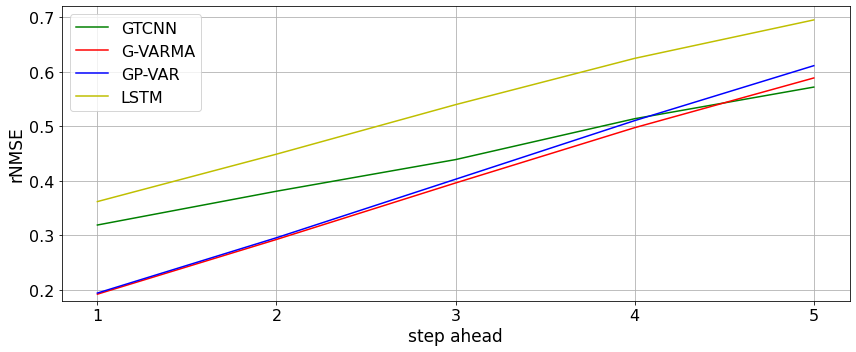

C:\Users\gabri\Desktop\new_thesis_project\prediction\MOLENE\runs_MOLENE_w=4_old\..\figures\


In [16]:
from matplotlib.ticker import MaxNLocator
g_varma_rNMSEs = [0.1921449, 0.29251406, 0.3961603, 0.49754531, 0.58871755]
gp_var_rNMSEs = [0.19419846, 0.29567637, 0.40296721, 0.51051343, 0.61125471]
lstm_rNMSEs = [0.362, 0.449, 0.5398, 0.6247, 0.6952]

model_number = 2
type_of_sort = 'val'  # 'tst'

if type_of_sort == 'val':
    print("Choosing based on validation performance.")
    name, dictionary = models_sorted_by_val[model_number]
elif type_of_sort == 'tst':
    print("Choosing based on test performance.")
    name, dictionary = models_sorted_by_tst[model_number]
else:
    raise Exception("Hey!")
    
print(name)
pretty_print_dict(dictionary)

gtcnn_values = dictionary['tst'][1]

ax = plt.figure(figsize=(12, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(steps_ahead, gtcnn_values, 'g', label='GTCNN')
plt.plot(steps_ahead, g_varma_rNMSEs, 'r', label='G-VARMA')
plt.plot(steps_ahead, gp_var_rNMSEs, 'b', label='GP-VAR')
plt.plot(steps_ahead, lstm_rNMSEs, 'y', label='LSTM')
# plt.plot(steps_ahead, persistence, 'y', label='Persistence')


plt.xlabel("step ahead", fontsize=17)
plt.ylabel("rNMSE", fontsize=17)
plt.legend(fontsize=16, loc="upper left")
#plt.title(name.split("_")[start-5:], fontsize=16)
plt.grid()
plt.ylim(0.18, 0.72)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

# 
plt.savefig("C:\\Users\\gabri\\Desktop\\molene_results_new.png")
plt.tight_layout()
plt.show()

print(figure_dir)

# Visualizing picked model

In [ ]:
checkpoint = torch.load(f"{runs_dir}/{name}/{naming}_one_step_gtcnn.pth") 

start = 5
name.split("_")[start]

In [ ]:
features = ast.literal_eval(name.split("_")[start].split("=")[1])
taps = ast.literal_eval(name.split("_")[start+1].split("=")[1])
pool_ratios = ast.literal_eval(name.split("_")[start+2].split("=")[1])
reach = ast.literal_eval(name.split("_")[start+3].split("=")[1])
nodes = ast.literal_eval(name.split("_")[start+4].split("=")[1])

cyclic_time_graph = 'cyclic=True' in name
time_directed = 'tdirect=False' not in name

feat_per_layer = [1] + features
taps_per_layer = taps
pool_reach_per_layer = reach
active_nodes_per_timestep_per_layer = [N_spatial_nodes] + nodes
time_pooling_ratio_per_layer = pool_ratios



one_step_gtcnn = ParametricNetWithPoolingOrdered(
    window=obs_window,
    cyclic_time_graph=cyclic_time_graph,
    time_directed=time_directed,
    S_spatial=weighted_adjacency,
    n_feat_per_layer=feat_per_layer,
    n_taps_per_layer=taps_per_layer,
    n_active_nodes_per_timestep_per_layer=active_nodes_per_timestep_per_layer,
    time_pooling_ratio_per_layer=time_pooling_ratio_per_layer,
    pool_reach_per_layer=pool_reach_per_layer,
    output_dim=N_spatial_nodes,
    device=device)

one_step_gtcnn.to(device)

one_step_gtcnn.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

one_step_gtcnn.eval()
print(f"{naming} model was at epoch: {epoch}")
print(name)

rNMSE_dict, predictions_dict = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, tst_data, tst_labels, device, verbose=False)


In [ ]:
node_to_visualize = 7 # 20 and 7  is good. 13 is terrible.
step_ahead = 3
pred = predictions_dict[step_ahead][:, node_to_visualize].cpu()
truth = tst_labels[:, step_ahead-1, node_to_visualize].cpu()
assert pred.shape == truth.shape
indices = list(range(truth.shape[0]))

truth_style = '-'
pred_style = ':'
# plot of all_data
plt.figure(figsize=(12, 6))
plt.plot(indices, truth[indices], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices, pred[indices], 'g', linestyle=pred_style, label='GTCNN', linewidth=3)  # plotting t, b separately

# title = f"Station {station_idx}: {station_names[station_idx]} ({station_num})"
plt.xlabel("Time (Hours)", fontsize=18)
plt.ylabel("Temperature (Kelvin degrees)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

plt.ylim(-12, 8)

plt.savefig(figure_dir + name.split('\\')[-1] + f"_typeOfSort={type_of_sort}_rank={model_number}_station{node_to_visualize}_step{step_ahead}.png")

plt.show()


print(epoch)
print(rNMSE_dict)

In [ ]:
# new_folder = "C:\\Users\\gabri\\Desktop\\exp_prediction_MOLENE\\good_experiments_obs=4\\"

# from distutils.dir_util import copy_tree

# for model_path, _ in best_models.items():
#     model_name = model_path.split("full")[1][1:]
    
#     old_model_dir = runs_dir + model_name
#     new_model_folder = new_folder + model_name
#     check_create_folder(new_model_folder)
#     copy_tree(old_model_dir, new_model_folder)